# Analysis of Antibiotics Prescription and Hospitalisation Risk

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
%matplotlib inline

In [2]:
#os.chdir("..")
current_working_dir = os.getcwd()
print(current_working_dir)

c:\Users\m84300af\OneDrive - The University of Manchester\Documents\GitHub\amr-uom-brit


In [68]:
#data = pd.read_csv(r'../output/measures/input_2019-01-01.csv.gz', compression='gzip')
##data = pd.read_csv(r'../output/measures/measure_antibiotics_overall_2019-01-01.csv')
#data.head(5)

In [4]:
#read csv.gz files and concatenate them
#path2 = os.getcwd()+'\output\measures'
##path1 = r'C:\Users\m84300af\OneDrive - The University of Manchester\Documents\GitHub\amr-uom-brit\output\measures'
##all_files = glob.glob(os.path.join(path1, "*.csv.gz"))
##print(path1)

##data = pd.concat((pd.read_csv(f) for f in all_files))
##data

In [3]:
data201901 = pd.read_csv(r'../output/measures/input_2019-01-01.csv.gz', compression='gzip')
data201901['date'] = '2019-01-01'
#data201901.head(3)

In [4]:
data201902 = pd.read_csv(r'../output/measures/input_2019-02-01.csv.gz', compression='gzip')
data201902['date'] = '2019-02-01'
data201902 = data201901.append(data201902, ignore_index=True)
#data201902.head(3)

In [5]:
data201903 = pd.read_csv(r'../output/measures/input_2019-03-01.csv.gz', compression='gzip')
data201903['date'] = '2019-03-01'
data201903 = data201902.append(data201903, ignore_index=True)
#data201903.head(3)

In [6]:
data201904 = pd.read_csv(r'../output/measures/input_2019-04-01.csv.gz', compression='gzip')
data201904['date'] = '2019-04-01'
data = data201903.append(data201904, ignore_index=True)
data.head(3)

,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,sgss_positive,covrx1_dat,covrx2_dat,died_date,uti_date_1,...,uti_ab_count_1,uti_ab_count_2,uti_ab_count_3,uti_ab_count_4,lrti_ab_count_1,lrti_ab_count_2,lrti_ab_count_3,lrti_ab_count_4,patient_id,date
0,2020-04,2020-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6,0,0,0,0,0,0,0,6603,2019-01-01
1,2012-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,6,0,0,0,0,0,6337,2019-01-01
2,2010-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-21,NaN,...,0,0,0,0,5,7,0,0,4339,2019-01-01


In [7]:
data.columns

Index(['bmi_date_measured', 'smoking_status_date',
       'most_recent_unclear_smoking_cat_date', 'flu_vaccine_med',
       'flu_vaccine_clinical', 'sgss_positive', 'covrx1_dat', 'covrx2_dat',
       'died_date', 'uti_date_1', 'uti_date_2', 'uti_date_3', 'uti_date_4',
       'lrti_date_1', 'lrti_date_2', 'lrti_date_3', 'lrti_date_4', 'age',
       'age_cat', 'sex', 'practice', 'region', 'msoa', 'imd', 'bmi',
       'ethnicity', 'smoking_status', 'gp_count', 'flu_vaccine_tpp',
       'flu_vaccine', 'antibacterial_prescriptions', 'antibacterial_brit',
       'broad_spectrum_antibiotics_prescriptions', 'primary_care_covid',
       'admitted', 'uti_counts', 'lrti_counts', 'urti_counts',
       'sinusitis_counts', 'ot_externa_counts', 'otmedia_counts', 'uti_pt',
       'lrti_pt', 'urti_pt', 'sinusitis_pt', 'ot_externa_pt', 'otmedia_pt',
       'uti_ab_count_1', 'uti_ab_count_2', 'uti_ab_count_3', 'uti_ab_count_4',
       'lrti_ab_count_1', 'lrti_ab_count_2', 'lrti_ab_count_3',
       'lrti_

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 57 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   bmi_date_measured                         3204 non-null   object 
 1   smoking_status_date                       400 non-null    object 
 2   most_recent_unclear_smoking_cat_date      400 non-null    object 
 3   flu_vaccine_med                           400 non-null    object 
 4   flu_vaccine_clinical                      400 non-null    object 
 5   sgss_positive                             400 non-null    object 
 6   covrx1_dat                                0 non-null      float64
 7   covrx2_dat                                0 non-null      float64
 8   died_date                                 400 non-null    object 
 9   uti_date_1                                400 non-null    object 
 10  uti_date_2                          

In [9]:
data.describe(include='all')

,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,sgss_positive,covrx1_dat,covrx2_dat,died_date,uti_date_1,...,uti_ab_count_1,uti_ab_count_2,uti_ab_count_3,uti_ab_count_4,lrti_ab_count_1,lrti_ab_count_2,lrti_ab_count_3,lrti_ab_count_4,patient_id,date
count,3204,400,400,400,400,400,0.0,0.0,400,400,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000
unique,142,35,35,12,7,329,NaN,NaN,195,323,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
top,2010-12,2020-10,2020-11,2018-03,2018-08,2021-09-27,NaN,NaN,2021-11-06,2019-01-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01
freq,34,17,18,42,70,4,NaN,NaN,8,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.898500,0.906750,0.893750,0.899500,0.901000,0.897500,0.898000,0.901000,4945.521500,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.855144,1.872547,1.845484,1.857219,1.863617,1.855763,1.854712,1.858376,2901.651526,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2354.750000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4904.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7450.250000,NaN


## Plots continuous columns

In [ ]:
#prep before plot

data['age'][data['age'] < 0] = np.nan

## remove died cases
#data.died_date.value_counts()

# remove cases with bmi equal 0
data['bmi'][data['bmi'] == 0] = np.nan

# Negative GP consultations mean what? Shall I remove them?

In [10]:
# function to generate histogram plots
def create_plot(title, df, ax):
    ax.hist(df, color = 'purple', edgecolor = 'black', bins=20)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=25)

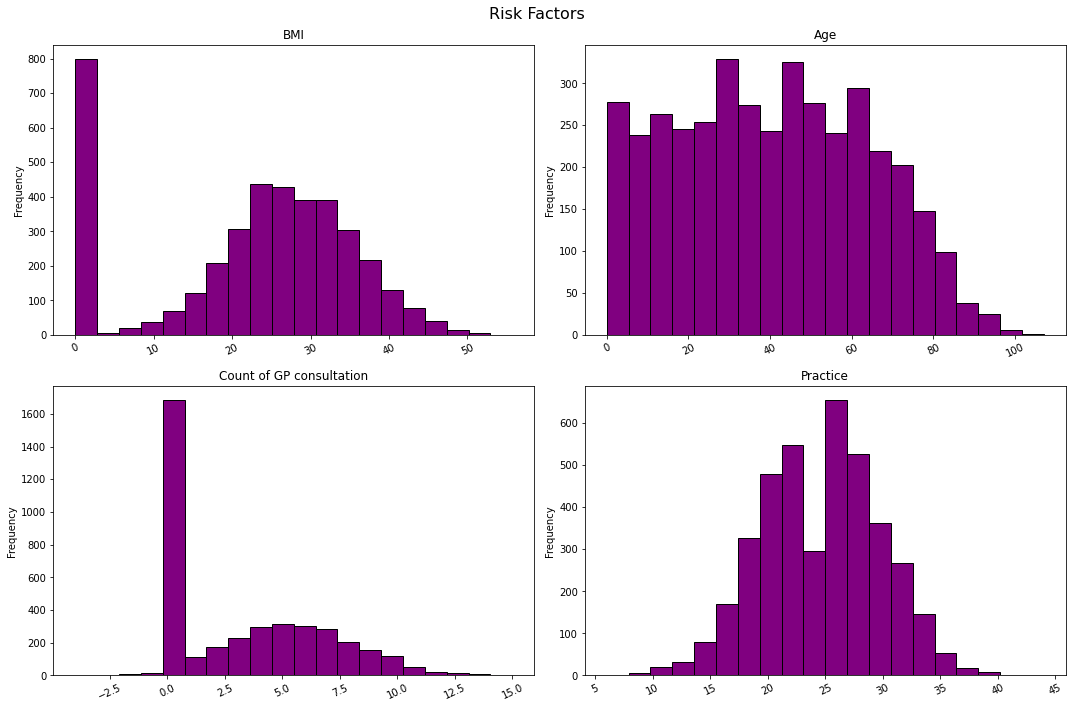

In [52]:
fig, axes = plt.subplots(2,2, 
                        figsize=(15, 10)
                        )
create_plot('BMI', data['bmi'], axes[0,0])
create_plot('Age', data['age'], axes[0,1])
create_plot('Count of GP consultation', data['gp_count'], axes[1,0])
create_plot('Practice', data['practice'], axes[1,1])
#fig.delaxes(ax=axes[1,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_risk/risk_factors_cont.jpg')
plt.show()

## Plot categorical columns

In [53]:
def create_lineplot(var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Frequency')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=25)

In [54]:
data.columns

Index(['bmi_date_measured', 'smoking_status_date',
       'most_recent_unclear_smoking_cat_date', 'flu_vaccine_med',
       'flu_vaccine_clinical', 'sgss_positive', 'covrx1_dat', 'covrx2_dat',
       'died_date', 'uti_date_1', 'uti_date_2', 'uti_date_3', 'uti_date_4',
       'lrti_date_1', 'lrti_date_2', 'lrti_date_3', 'lrti_date_4', 'age',
       'age_cat', 'sex', 'practice', 'region', 'msoa', 'imd', 'bmi',
       'ethnicity', 'smoking_status', 'gp_count', 'flu_vaccine_tpp',
       'flu_vaccine', 'antibacterial_prescriptions', 'antibacterial_brit',
       'broad_spectrum_antibiotics_prescriptions', 'primary_care_covid',
       'admitted', 'uti_counts', 'lrti_counts', 'urti_counts',
       'sinusitis_counts', 'ot_externa_counts', 'otmedia_counts', 'uti_pt',
       'lrti_pt', 'urti_pt', 'sinusitis_pt', 'ot_externa_pt', 'otmedia_pt',
       'uti_ab_count_1', 'uti_ab_count_2', 'uti_ab_count_3', 'uti_ab_count_4',
       'lrti_ab_count_1', 'lrti_ab_count_2', 'lrti_ab_count_3',
       'lrti_

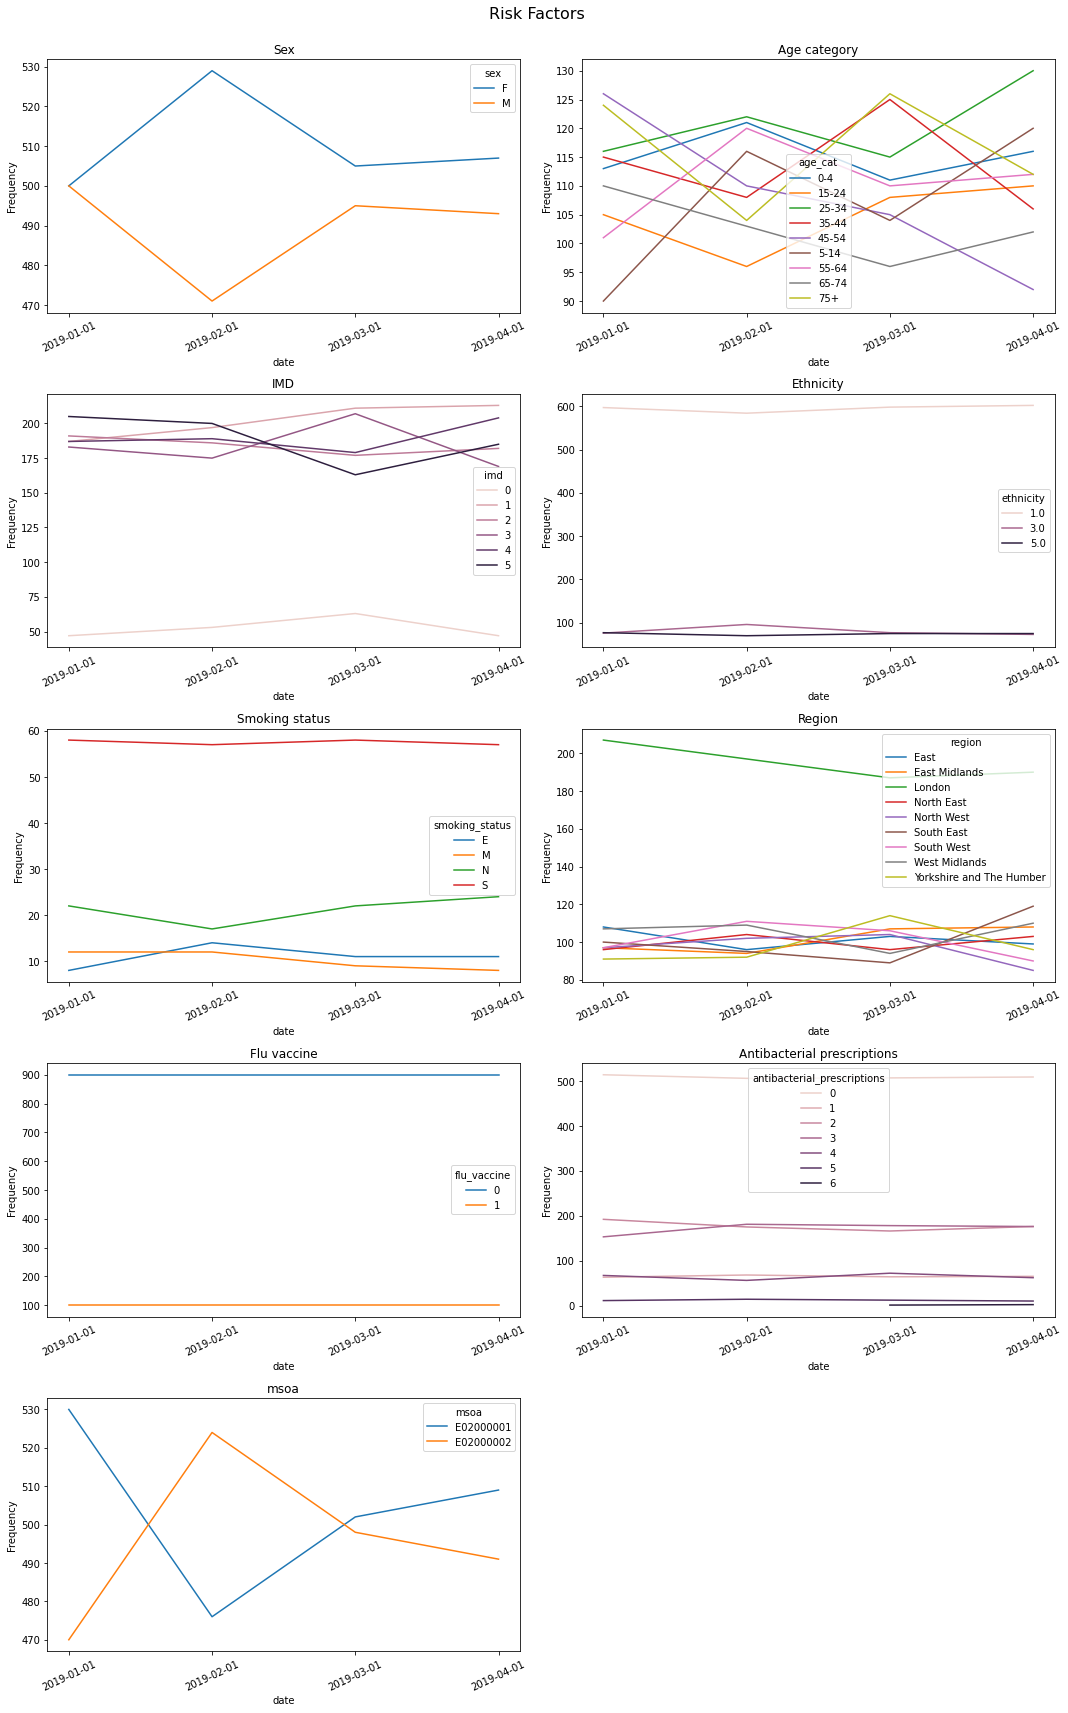

In [73]:
fig, axes = plt.subplots(5,2,
                        figsize=(15, 25)
                        )
create_lineplot('sex', 'Sex', axes[0,0])
create_lineplot('age_cat', 'Age category', axes[0,1])
create_lineplot('imd', 'IMD', axes[1,0])
create_lineplot('ethnicity', 'Ethnicity', axes[1,1])
create_lineplot('smoking_status', 'Smoking status', axes[2,0])
create_lineplot('region', 'Region', axes[2,1])
create_lineplot('flu_vaccine', 'Flu vaccine', axes[3,0])
create_lineplot('antibacterial_prescriptions', 'Antibacterial prescriptions', axes[3,1])
create_lineplot('msoa', 'msoa', axes[4,0])
fig.delaxes(ax=axes[4,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_risk/risk_factors_cat.jpg')
plt.show()

## How would we exclude died persons? Those who died before today? 

In [61]:
#ax = data['practice'].value_counts(np.nan).sort_index().plot(kind='bar', figsize=(10, 5), rot=0, color = 'blue', alpha=0.5)
#plt.xlabel('Practice')
#plt.ylabel('Percentage')
#plt.title('Percentage of practices')
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
##plt.xlim(0, 100)
##plt.ylim(0, 1)
#plt.grid()
#plt.savefig(r'../output/hospitalisation_risk/practices.png', edgecolor='none')
#plt.show()

In [62]:
#sns.distplot(data['age'], hist=True, kde=True, 
#             bins=15, color = 'blue', 
#             #hist_kws={'edgecolor':'black'},
#             kde_kws={'linewidth': 2})

#plt.xlabel('Age')
##plt.ylabel('Frequency')
#plt.title('Histogram of age')
#plt.xlim(-10, 100)
##plt.ylim(0, 1100)
#plt.grid(True)
##plt.savefig(r'../output/hospitalisation_risk/antibacterial_prescirption.png', edgecolor='none')
#plt.show()

In [63]:
##data['age_cat'].value_counts().sort_index()

#data['age_cat'].value_counts(np.nan).sort_index().plot(kind='bar', figsize=(10, 5), rot=0, color = 'blue', alpha=0.5)
#plt.xlabel('Age category')
#plt.ylabel('Percentage')
#plt.title('Percentage of age categories')
##plt.xlim(0, 100)
#plt.ylim(0, 0.15)
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#plt.grid()
#print(data['age_cat'].value_counts().sort_index())
#plt.savefig(r'../output/hospitalisation_risk/age_categories.png', edgecolor='none')
#plt.show()

In [64]:
#for i, binwidth in enumerate([1, 5, 10, 15]):
    
#    # Set up the plot
#    ax = plt.subplot(2, 2, i + 1)
#    
#    # Draw the plot
#    ax.hist(data['bmi'], bins = int(180/binwidth), 
#             color = 'blue', edgecolor = 'black')
    
#    # Title and labels
#    ax.set_title('Histogram with Binwidth = %d' % binwidth, size = 10)
#    ax.set_xlabel('Delay (min)', size = 12)
#    ax.set_ylabel('Flights', size= 12)

#plt.tight_layout()
#plt.show()

In [65]:
#fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
#fig.suptitle('Vertically stacked subplots')

#ax1.hist(data['bmi'], bins = int(180/1), color = 'blue', edgecolor = 'black')
#ax2.hist(data['bmi'], bins = int(180/5), color = 'blue', edgecolor = 'black')
#ax3.hist(data['bmi'], bins = int(180/10), color = 'blue', edgecolor = 'black')
#ax4.hist(data['bmi'], bins = int(180/15), color = 'blue', edgecolor = 'black')

#plt.tight_layout()
#plt.show()

In [66]:
#fig, axs = plt.subplots(2, 2, 
#                        #figsize=(18, 14)
#                        )

#axs[0, 0].hist(data['bmi'], bins = int(180/1), color = 'blue', edgecolor = 'black')
#axs[0, 1].hist(data['bmi'], bins = int(180/5), color = 'blue', edgecolor = 'black')
#axs[1, 0].hist(data['bmi'], bins = int(180/10), color = 'blue', edgecolor = 'black')
#axs[1, 1].hist(data['bmi'], bins = int(180/15), color = 'blue', edgecolor = 'black')

#plt.tight_layout()
#plt.show()

In [67]:
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
#fig.suptitle('Vertically stacked subplots')

#ax1.hist(data['bmi'], bins = int(180/1), color = 'blue', edgecolor = 'black')
#ax2.hist(data['bmi'], bins = int(180/5), color = 'blue', edgecolor = 'black')
#ax3.hist(data['bmi'], bins = int(180/10), color = 'blue', edgecolor = 'black')
#ax4.hist(data['bmi'], bins = int(180/15), color = 'blue', edgecolor = 'black')

#for ax in fig.get_axes():
#    ax.label_outer()
#    ax.set(xlabel='x-label', ylabel='y-label')

#plt.tight_layout()
#plt.show()

(0.0, 100.0)

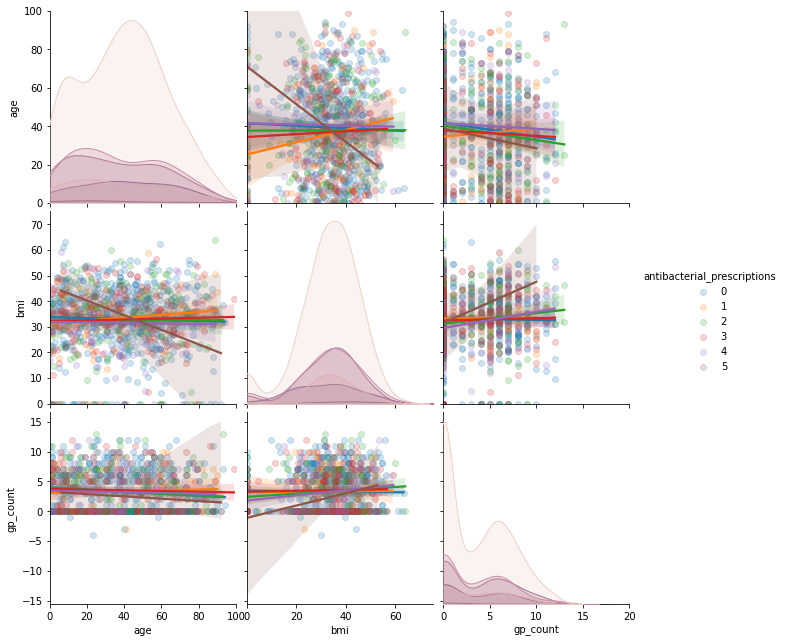

In [36]:
p = sns.pairplot(data, vars=['age', 'bmi', 'gp_count'#, 'practice'
                             ], hue = 'antibacterial_prescriptions', kind='reg', #markers=["o", "s"], 
                 diag_kind="kde"#"hist"
                 , plot_kws={#'line_kws':{'color':'red'}, 
                 'scatter_kws': {'alpha': 0.2}}, 
                 height = 3)

p.axes[0,2].set_xlim((0,20))
p.axes[0,2].set_ylim((0,100))

p.axes[1,1].set_xlim((0,75))
p.axes[1,1].set_ylim((0,75))

p.axes[2,0].set_xlim((0,100))
#p.axes[2,0].set_ylim((0,20))

(0.0, 20.0)

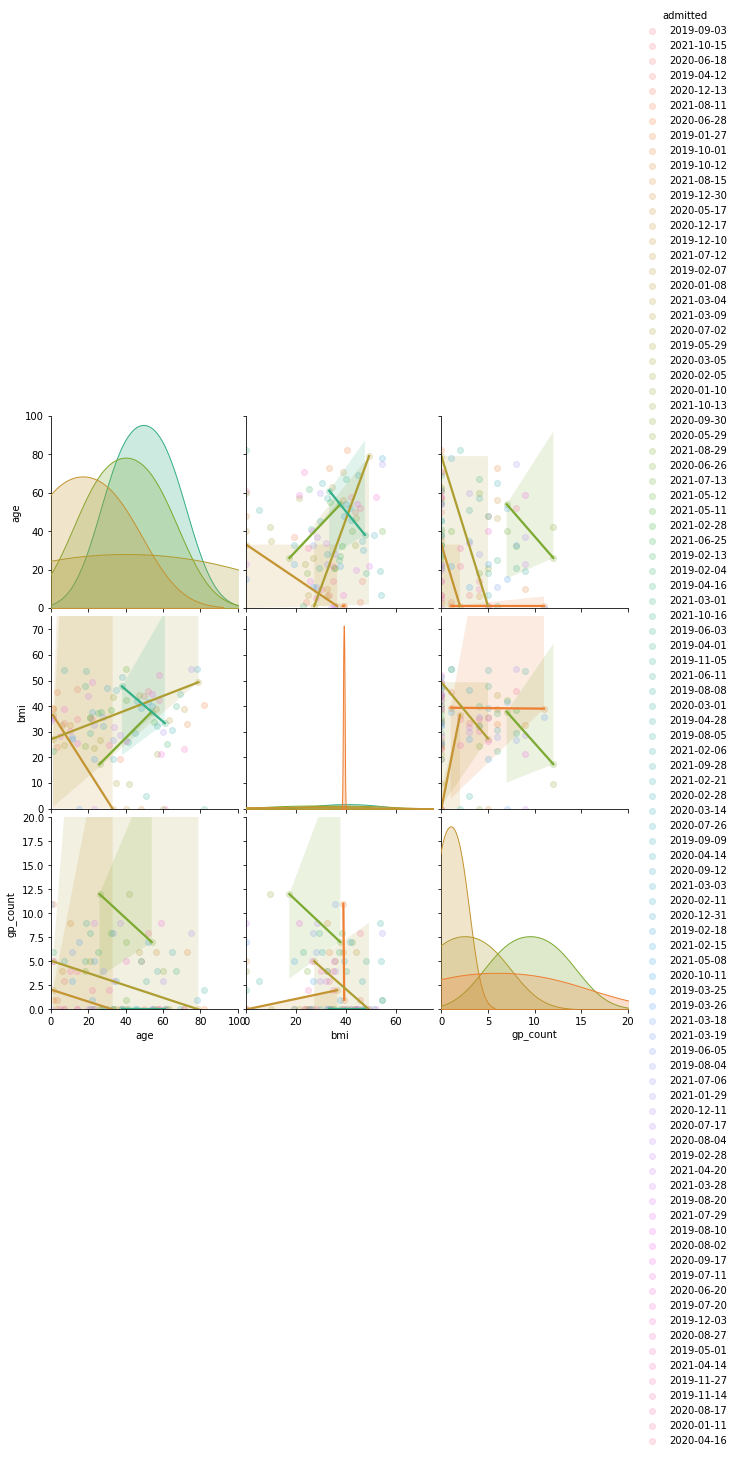

In [37]:
p = sns.pairplot(data, vars=['age', 'bmi', 'gp_count'#, 'practice'
                             ], hue = 'admitted', kind='reg', #markers=["o", "s"], 
                 diag_kind="kde"#"hist"
                 , plot_kws={#'line_kws':{'color':'red'}, 
                 'scatter_kws': {'alpha': 0.2}}, height = 3)

p.axes[0,2].set_xlim((0,20))
p.axes[0,2].set_ylim((0,100))

p.axes[1,1].set_xlim((0,75))
p.axes[1,1].set_ylim((0,75))

p.axes[2,0].set_xlim((0,100))
p.axes[2,0].set_ylim((0,20))